# Notebook to generate plots for presentation so that I don't mess up the code in the other ones

In [1]:
from rascil.processing_components import create_visibility_from_ms
from visibilities import *
from images import *
import matplotlib.pyplot as plt
import matplotlib
import numpy
import helpers
from scipy import signal
import pandas as pd

plt.set_loglevel("critical")
cmap='turbo'
matplotlib.rcParams['figure.figsize'] = [10, 5]

niter = 100

## For testing/comparing partition configuration

### Load data and compute rmses

In [2]:
gt = helpers.readFits("../data/SGRA_full_gt.fits")

cuts = [20, 55]
hws = [5, 1]
dataset_names = ["Sgr A"]
actual_names = ["SGRA"]

data_low = []
data_high = []

noiseless = False
weight = "uniform"
lambdam = 2

for i, dataset in enumerate(actual_names):
    for j, cut in enumerate(cuts):
        for k, hw in enumerate(hws):
            rmses_full_lowres = []
            rmses_low_lowres = []
            rmses_full_fullres = []
            rmses_low_fullres = []
            
            path =  "../results/cut_results/" + dataset + "/" + str(cut) + "/" + str(hw) + "hw/bphigh/lambda_m" + str(lambdam) + "/"
            
            low_gt_filter = helpers.bandpass(gt, 0, cut + hw)
            low_gt = signal.fftconvolve(gt, low_gt_filter, mode='same')
            
            curr_deconv_low = None
            curr_deconv_high = None
            for maj_iter in range(0, 5):
                high_filename = path + "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
                low_filename = "../results/cut_results/" + dataset + "/" + str(cut) + "/" + str(hw) + "hw/low/" + \
                    "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
                deconv_low = helpers.readFits(low_filename)
                deconv_high = helpers.readFits(high_filename)
                
                if curr_deconv_low is None:
                    curr_deconv_low = deconv_low
                else:
                    curr_deconv_low += deconv_low
                
                if curr_deconv_high is None:
                    curr_deconv_high = deconv_high
                else:
                    curr_deconv_high += deconv_high
                
                rmse_low_lowres = helpers.compute_rmse(low_gt, signal.fftconvolve(curr_deconv_low, low_gt_filter, mode='same'))
                rmse_full_lowres = helpers.compute_rmse(low_gt, signal.fftconvolve(curr_deconv_high, low_gt_filter, mode='same'))
                rmse_low_fullres = helpers.compute_rmse(gt, curr_deconv_low)
                rmse_full_fullres = helpers.compute_rmse(gt, curr_deconv_high)
                
                rmses_full_lowres.append(rmse_full_lowres)
                rmses_low_lowres.append(rmse_low_lowres)
                rmses_full_fullres.append(rmse_full_fullres)
                rmses_low_fullres.append(rmse_low_fullres)

            data_low.append(rmses_low_lowres + rmses_full_lowres)
            data_high.append(rmses_low_fullres + rmses_full_fullres)

### Progression of low-resolution rmse across both low and high steps

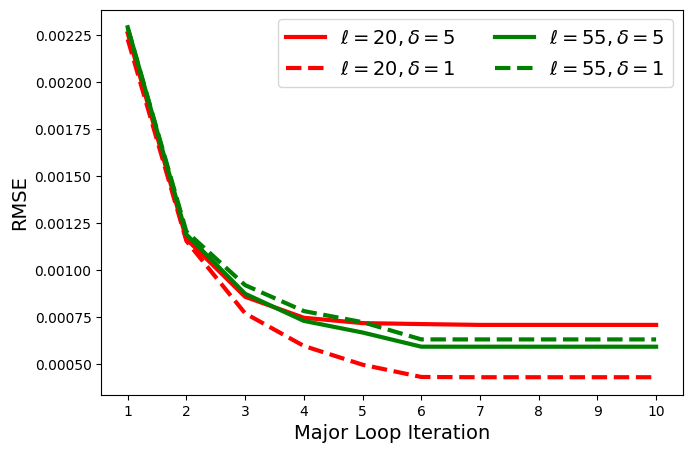

In [3]:
matplotlib.rcParams['figure.figsize'] = [7.5, 5]
from functools import partial

colours = ['r', 'r', 'g', 'g']
styles = ['-', '--', '-', '--']

labels = ["$\ell=20, \delta=5$", "$\ell=20, \delta=1$", "$\ell=55, \delta=5$", "$\ell=55, \delta=1$"]

for i, data in enumerate(data_low):
    plt.plot(range(1, 11), data, c=colours[i], linestyle=styles[i], label=labels[i], lw=3)

plt.xticks(range(1, 11))

plt.legend(loc="upper right", fontsize=14, ncol=2)
    
plt.xlabel("Major Loop Iteration", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.savefig("../figures/presentation/multistep_rmse_low.png", bbox_inches='tight')

### Progression of full-resolution rmse across both low and high steps

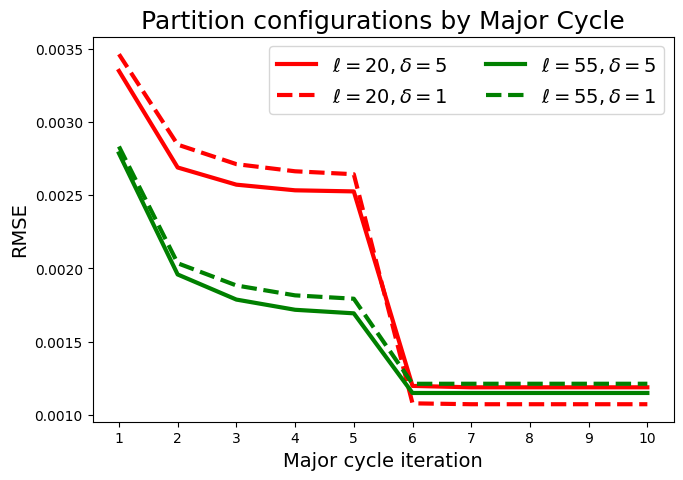

In [4]:
matplotlib.rcParams['figure.figsize'] = [7.5, 5]
from functools import partial

colours = ['r', 'r', 'g', 'g']
styles = ['-', '--', '-', '--']

labels = ["$\ell=20, \delta=5$", "$\ell=20, \delta=1$", "$\ell=55, \delta=5$", "$\ell=55, \delta=1$"]

for i, data in enumerate(data_high):
    plt.plot(range(1, 11), data, c=colours[i], linestyle=styles[i], label=labels[i], lw=3)

plt.xticks(range(1, 11))

plt.title("Partition configurations by Major Cycle", fontsize=18)
plt.legend(loc="upper right", fontsize=14, ncol=2)
    
plt.xlabel("Major cycle iteration", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.savefig("../figures/presentation/multistep_rmse_full1.png", bbox_inches='tight')

### Compared to single step for major-cycles

In [5]:
gt = helpers.readFits("../data/SGRA_full_gt.fits")
lowcut = 25.0001

highcut = 75

single_low = []
single_full = []
single_high = []
single2_low = []
single2_high = []
single2_full = []
multi_high = []

curr_deconv_single = None
curr_deconv_single2 = None

lpfilter = helpers.bandpass(gt, 0, lowcut)
hpfilter = helpers.bandpass(gt, highcut, 500)
lowgt = signal.fftconvolve(gt, lpfilter, mode='same')
highgt = signal.fftconvolve(gt, hpfilter, mode='same')

for maj_iter in range(0, 10):
    single_filename1 = "../results/cut_results/full_recons/SGRA/10mi2/deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
    single_filename2 = "../results/cut_results/full_recons/SGRA/10mi/deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
    
    deconv_single = helpers.readFits(single_filename1)
    deconv_single2 = helpers.readFits(single_filename2)

    if curr_deconv_single is None:
        curr_deconv_single = deconv_single
        curr_deconv_single2 = deconv_single2
    else:
        curr_deconv_single += deconv_single
        curr_deconv_single2 += deconv_single2
    
    single_lp_deconv = signal.fftconvolve(curr_deconv_single, lpfilter, mode='same')
    single_hp_deconv = signal.fftconvolve(curr_deconv_single, hpfilter, mode='same')
    
    single2_lp_deconv = signal.fftconvolve(curr_deconv_single2, lpfilter, mode='same')
    single2_hp_deconv = signal.fftconvolve(curr_deconv_single2, hpfilter, mode='same')
        
    rmse_single_full = helpers.compute_rmse(gt, curr_deconv_single)
    rmse_single_low = helpers.compute_rmse(lowgt, single_lp_deconv)
    rmse_single_high = helpers.compute_rmse(highgt, single_hp_deconv)
    
    rmse_single2_full = helpers.compute_rmse(gt, curr_deconv_single2)
    rmse_single2_low = helpers.compute_rmse(lowgt, single2_lp_deconv)
    rmse_single2_high = helpers.compute_rmse(highgt, single2_hp_deconv)
    
    single_low.append(rmse_single_low)
    single_full.append(rmse_single_full)
    single_high.append(rmse_single_high)
    
    single2_low.append(rmse_single2_low)
    single2_full.append(rmse_single2_full)
    single2_high.append(rmse_single2_high)

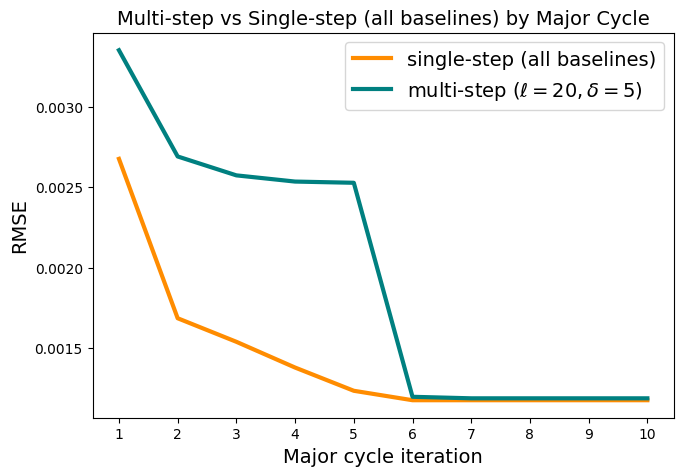

In [6]:
plt.plot(range(1, 11), single_full, c='darkorange', label="single-step (all baselines)", lw=3)
plt.plot(range(1, 11), data_high[0], c='teal', label="multi-step ($\ell=20, \delta=5$)", lw=3)
#plt.plot(range(1, 11), single2_full, c='b', label="single-step2", lw=3)

plt.legend(loc="upper right",  fontsize=14)
plt.xticks(range(1, 11))
plt.title("Multi-step vs Single-step (all baselines) by Major Cycle", fontsize=14)
plt.xlabel("Major cycle iteration", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.savefig("../figures/presentation/singlevsmulti_majcyc.png", bbox_inches='tight')

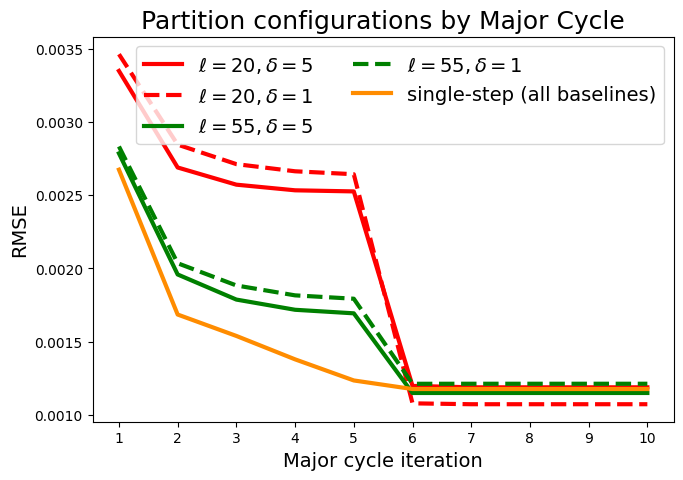

In [7]:
matplotlib.rcParams['figure.figsize'] = [7.5, 5]
from functools import partial

colours = ['r', 'r', 'g', 'g']
styles = ['-', '--', '-', '--']

labels = ["$\ell=20, \delta=5$", "$\ell=20, \delta=1$", "$\ell=55, \delta=5$", "$\ell=55, \delta=1$"]

for i, data in enumerate(data_high):
    plt.plot(range(1, 11), data, c=colours[i], linestyle=styles[i], label=labels[i], lw=3)
plt.plot(range(1, 11), single_full, c='darkorange', label="single-step (all baselines)", lw=3)
plt.xticks(range(1, 11))

plt.title("Partition configurations by Major Cycle", fontsize=18)
plt.legend(loc="upper right", fontsize=14, ncol=2)
    
plt.xlabel("Major cycle iteration", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.savefig("../figures/presentation/multistep_rmse_full.png", bbox_inches='tight')

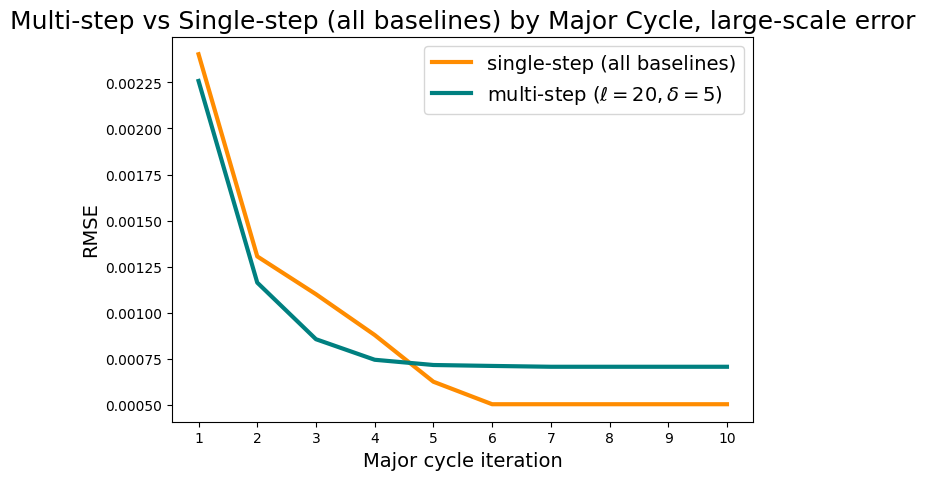

In [8]:
plt.plot(range(1, 11), single_low, c='darkorange', label="single-step (all baselines)", lw=3)
plt.plot(range(1, 11), data_low[0], c='teal', label="multi-step ($\ell=20, \delta=5$)", lw=3)
#plt.plot(range(1, 11), single2_low, c='b', label="single-step2", lw=3)

plt.legend(loc="upper right",  fontsize=14)
plt.xticks(range(1, 11))
plt.title("Multi-step vs Single-step (all baselines) by Major Cycle, large-scale error", fontsize=18)
plt.xlabel("Major cycle iteration", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.savefig("../figures/presentation/singlevsmulti_majcyc_lowres.png", bbox_inches='tight')

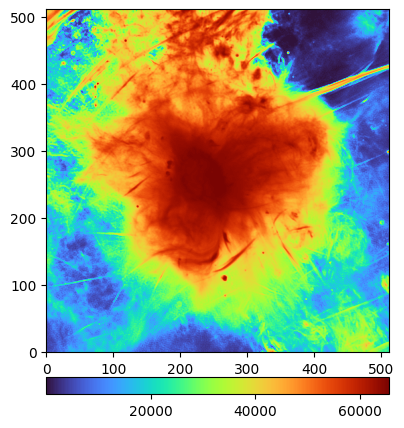

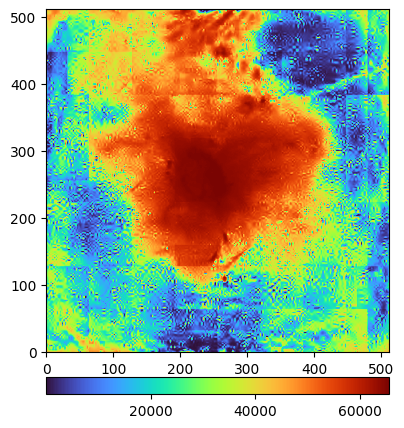

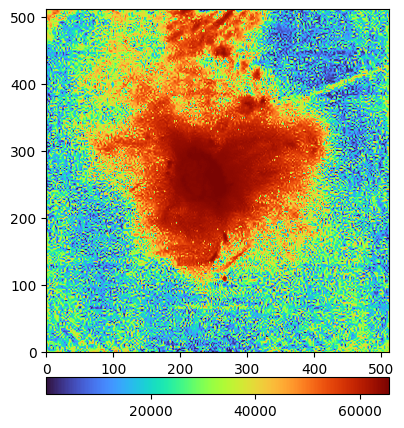

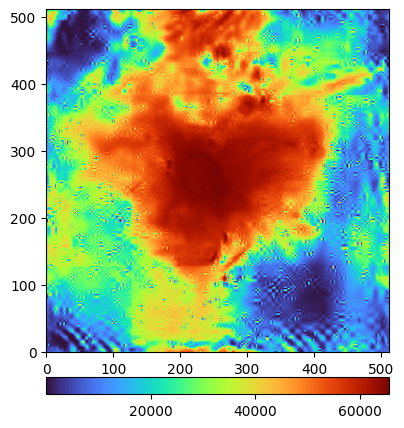

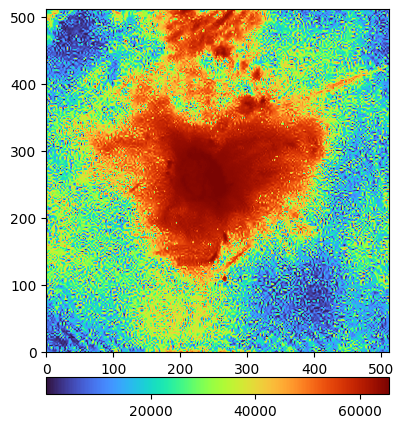

In [9]:
matplotlib.rcParams['figure.figsize'] = [10, 5]

single_recon = helpers.readFits("../results/cut_results/full_recons/SGRA/10mi2/SGRA_nmoment4_cip_deconvolved.fits")
multi_recon = helpers.readFits("../results/cut_results/SGRA/20/5hw/high/SGRA_long_baselines_15_nmoment4_cip_deconvolved.fits")
single2_recon = helpers.readFits("../results/cut_results/full_recons/SGRA/10mi/SGRA_nmoment4_cip_deconvolved.fits")
multi2_recon = helpers.readFits("../results/cut_results/SGRA/20/5hw/bphigh/lambda_m1/SGRA_long_baselines_15_nmoment4_cip_deconvolved.fits")

single_equalized = helpers.image_histogram_equalization(single_recon, 2**16)
multi_equalized = helpers.image_histogram_equalization(multi_recon, 2**16)
single2_equalized = helpers.image_histogram_equalization(single2_recon, 2**16)
multi2_equalized = helpers.image_histogram_equalization(multi2_recon, 2**16)
gt_equalized = helpers.image_histogram_equalization(gt, 2**16)

rmse_single1 = round(helpers.compute_rmse(single_recon, gt), 5)
rmse_single2 = round(helpers.compute_rmse(single2_recon, gt), 5)
rmse_multi1 = round(helpers.compute_rmse(multi_recon, gt), 5)
rmse_multi2 = round(helpers.compute_rmse(multi2_recon, gt), 5)

helpers.plotNImages([gt_equalized], [""], cmap, output_file="../figures/presentation/gt.png")
helpers.plotNImages([single_equalized], [""], cmap, output_file="../figures/presentation/single_largerlambda.png")
helpers.plotNImages([single2_equalized], [""], cmap, output_file="../figures/presentation/single_smallerlambda.png")
helpers.plotNImages([multi_equalized], [""], cmap, output_file="../figures/presentation/multi_largerlambda.png")
helpers.plotNImages([multi2_equalized], [""], cmap, output_file="../figures/presentation/multi_smallerlambda.png")

## To show that we can still reduce the residual for the multi-step, but the rmse will get worse

In [10]:
gt = helpers.readFits("../data/SGRA_full_gt.fits")

cut = 20
hw = 5
dataset = "SGRA"

rmses = []
l2norms = []

weighting = "uniform"
lambdam = 1

path = "../results/cut_results/" + dataset + "/" + str(cut) + "/" + str(hw) + "hw/bphigh/lambda_m" + str(lambdam) + "/"

low_gt_filter = helpers.bandpass(gt, 0, cut + hw)
low_gt = signal.fftconvolve(gt, low_gt_filter, mode='same')

curr_deconv_low = None
curr_deconv_high = None
for maj_iter in range(0, 5):
    high_filename = path + "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
    residual_filename = path + "dirty_iteration_" + str(maj_iter) + "_channel_0.fits"
    deconv_high = helpers.readFits(high_filename)
    residual = helpers.readFits(residual_filename)

    if curr_deconv_high is None:
        curr_deconv_high = deconv_high
    else:
        curr_deconv_high += deconv_high

    curr_rmse = helpers.compute_rmse(gt, curr_deconv_high)
    curr_residual_l2 = numpy.linalg.norm(residual)

    rmses.append(curr_rmse)
    l2norms.append(curr_residual_l2)

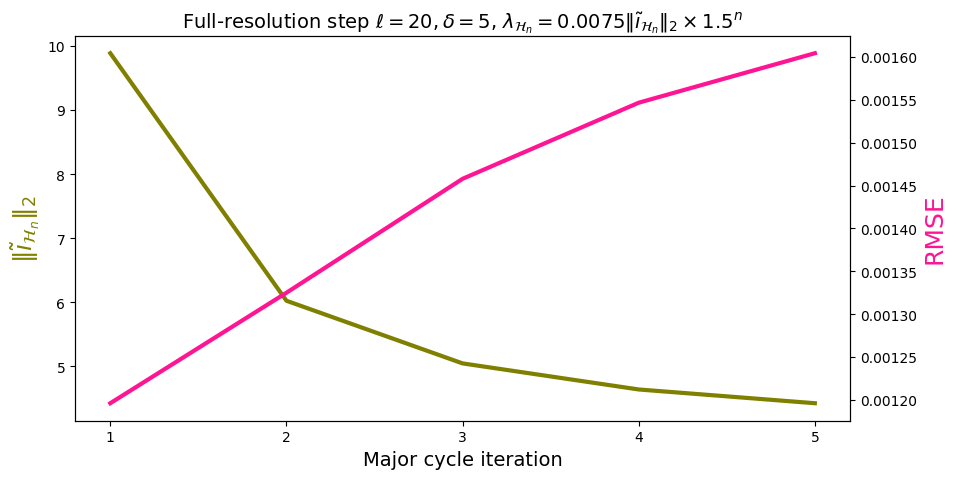

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(range(1, 6), l2norms, c="olive", label="\|\tilde{\imath}\|_2", lw=3)
ax2.plot(range(1, 6), rmses, c="deeppink", label="$rmse", lw=3)

plt.title(r'Full-resolution step $\ell=20, \delta=5$, $\lambda_{\mathcal{H}_n} = 0.0075 \|\tilde{\imath}_{\mathcal{H}_n}\|_2 \times 1.5^n$', fontsize=14)
ax1.set_xlabel("Major cycle iteration", fontsize=14)
ax1.set_ylabel(r'$\|\tilde{\imath}_{\mathcal{H}_n}\|_2$', color='olive', fontsize=18)
ax2.set_ylabel('RMSE', color='deeppink', fontsize=18)

plt.xticks(range(1, 6))

plt.savefig("../figures/presentation/l2_vs_rmse.png", bbox_inches='tight')

## Evolution of cost function across minor-cycle (ie. FISTA in our case) iterations

### For low resolution step

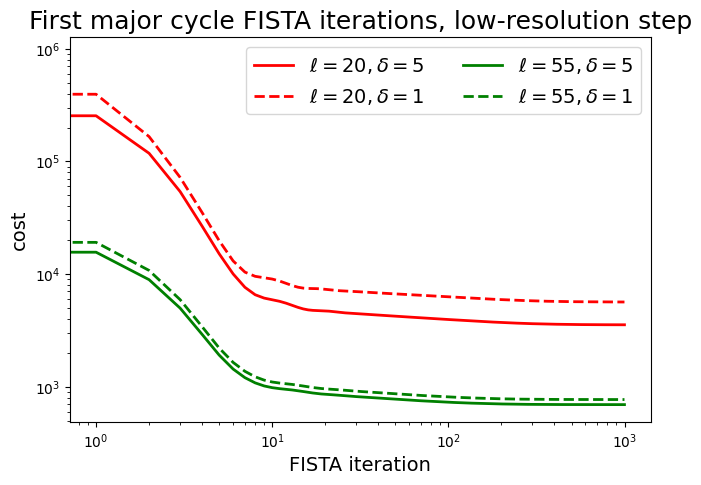

In [12]:
cuts = [20, 55]
deltas = [5, 1]
matplotlib.rcParams['figure.figsize'] = [7.5, 5]

colours = ['r', 'g']
lstyles = ['-', '--']

labels = [["$\ell=20, \delta=5$", "$\ell=20, \delta=1$"], 
          ["$\ell=55, \delta=5$", "$\ell=55, \delta=1$"]]

for i, cut in enumerate(cuts):
    for j, delta in enumerate(deltas):
        dirty = helpers.readFits("../data/SGRA_low" + str(cut + delta) + "_dirty.fits")
        dirty_norm = numpy.linalg.norm(dirty.flatten())
        
        csv_name = "../results/cut_results/fista_convergence/SGRA_cost_low" + str(cut + delta) + ".csv"
        data = helpers.read_csv(csv_name)
        data = data[1:]
        data = [float(x) for x in data]
        
        plt.plot(range(0, len(data)), data, c=colours[i], linestyle=styles[j], label=labels[i][j], lw=2)
plt.title("First major cycle FISTA iterations, low-resolution step", fontsize=18)
#plt.xlim([-1, 200])
plt.xscale('log')
plt.legend(loc="upper right", fontsize=14, ncol=2)
plt.yscale('log')
plt.xlabel("FISTA iteration", fontsize=14)
plt.ylabel(r"cost", fontsize=14)
plt.savefig("../figures/presentation/low_fista_conv.png", bbox_inches='tight')
        

### For full-resolution step

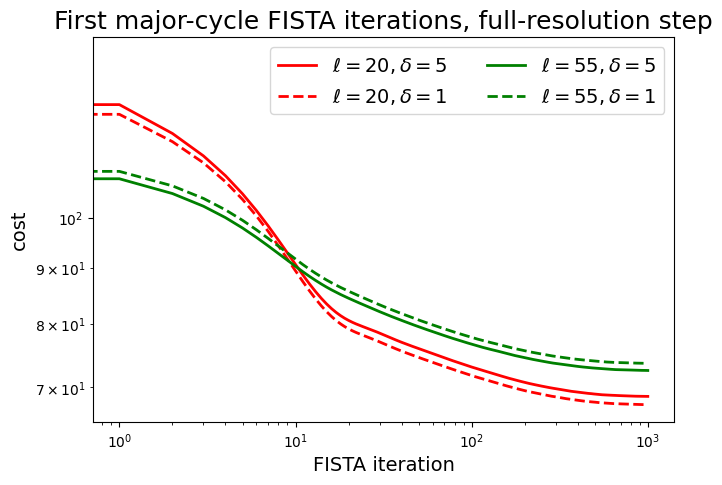

In [13]:
cuts = [20, 55]
actual_names = ["SGRA", "SGRB", "SGRC"]
deltas = [5, 1]
matplotlib.rcParams['figure.figsize'] = [7.5, 5]

colours = ['r', 'g']
lstyles = ['-', '--']

labels = [["$\ell=20, \delta=5$", "$\ell=20, \delta=1$"], 
          ["$\ell=55, \delta=5$", "$\ell=55, \delta=1$"]]

for i, cut in enumerate(cuts):
    for j, delta in enumerate(deltas):
        dirty = helpers.readFits("../data/SGRA_low" + str(cut + delta) + "_dirty.fits")
        dirty_norm = numpy.linalg.norm(dirty.flatten())
        
        csv_name = "../results/cut_results/fista_convergence/SGRA_cost_high" + str(cut - delta) + ".csv"
        data = helpers.read_csv(csv_name)
        data = data[1:]
        data = [float(x) for x in data]
        
        plt.plot(range(0, len(data)), data, c=colours[i], linestyle=styles[j], label=labels[i][j], lw=2)

        plt.title("First major-cycle FISTA iterations, full-resolution step", fontsize=18)
plt.xscale('log')
plt.legend(loc="upper right", fontsize=14, ncol=2)
plt.yscale('log')
plt.xlabel("FISTA iteration", fontsize=14)
plt.ylabel(r"cost", fontsize=14)
plt.savefig("../figures/presentation/full_fista_conv.png", bbox_inches='tight')
        

### All-baselines reconstruction

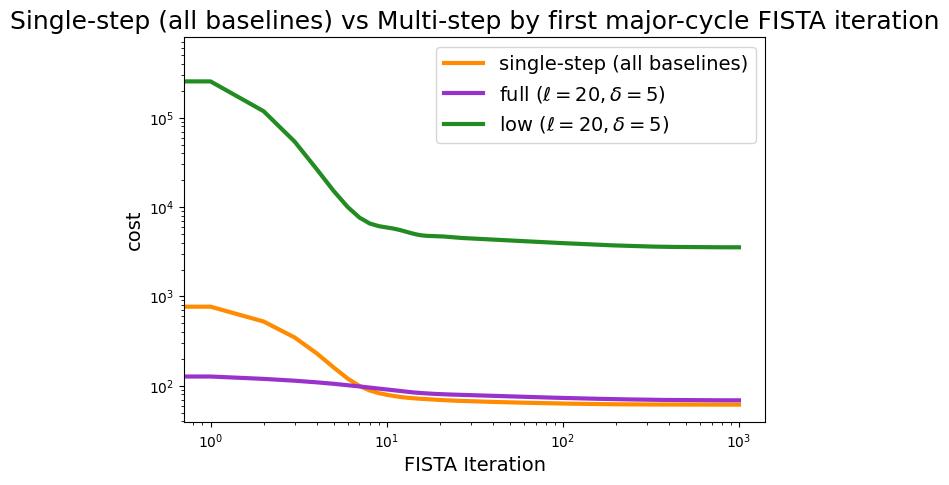

In [14]:
single_costs = "../results/cut_results/fista_convergence/SGRA_cost_full.csv"
high_costs = "../results/cut_results/fista_convergence/SGRA_cost_high15.csv"
low_costs = "../results/cut_results/fista_convergence/SGRA_cost_low25.csv"

def read_costs(filename):
    data = helpers.read_csv(filename)
    data = data[1:]
    data = [float(x) for x in data]
    
    return data

sc_dat = read_costs(single_costs)
hc_dat = read_costs(high_costs)
lc_dat = read_costs(low_costs)

plt.plot(range(0, len(sc_dat)), sc_dat, c="darkorange", label="single-step (all baselines)", lw=3)
plt.plot(range(0, len(hc_dat)), hc_dat, c="darkorchid", label="full ($\ell=20, \delta=5$)", lw=3)
plt.plot(range(0, len(lc_dat)), lc_dat, c="forestgreen", label="low ($\ell=20, \delta=5$)", lw=3)
plt.title("Single-step (all baselines) vs Multi-step by first major-cycle FISTA iteration", fontsize=18)
plt.legend(loc="upper right", fontsize=14)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("FISTA Iteration", fontsize=14)
plt.ylabel(r"cost", fontsize=14)
plt.savefig("../figures/presentation/singlevsmulti_fista_conv.png", bbox_inches='tight')
        

## Pipelined parallel results

In [15]:
gt = helpers.readFits("../data/SGRA_full_gt.fits")

cut = 20
hw = 5

data_pipelined = []
curr_deconv = None

for maj_iter in range(0, 5):
    high_filename = "../results/pipelined_results/SGRA/" + str(cut) + "/" + str(hw) + "hw/high/" + \
        "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
    low_filename = "../results/pipelined_results/SGRA/" + str(cut) + "/" + str(hw) + "hw/low/" + \
        "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"

    deconv = helpers.readFits(high_filename)

    if curr_deconv is None:
        curr_deconv = deconv
    else:
        curr_deconv += deconv

    rmse = helpers.compute_rmse(gt, curr_deconv)
    #append twice as it technically takes 2 major cycles to get the next full resolution image
    data_pipelined.append(rmse)
    data_pipelined.append(rmse)

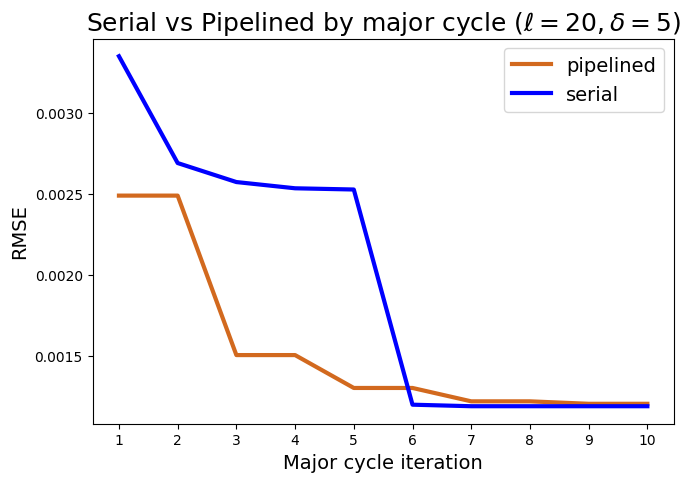

In [16]:
plt.plot(range(1, 11), data_pipelined, c="chocolate", label="pipelined", lw=3)
plt.plot(range(1, 11), data_high[0], c="blue", label="serial", lw=3)

plt.xticks(range(1, 11))
plt.title("Serial vs Pipelined by major cycle ($\ell=20, \delta=5$)", fontsize=18)
plt.legend(loc="upper right", fontsize=14)
    
plt.xlabel("Major cycle iteration", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.savefig("../figures/presentation/pipelined_vs_serial.png")

## Interleaved parallel results

In [17]:
dataset_name = "SGRA"
cut_center = 20
cut_halfwidth = 5
dataset_path = "../data4/"
num_pixels = 512
cell_size = 0.00001849451
weighting = 'uniform'
robustness = 0.0

small_baselines_msname = dataset_path + dataset_name + "_small_baselines_" + str(cut_center + cut_halfwidth) + ".ms"
long_baselines_msname = dataset_path + dataset_name + "_long_baselines_" + str(cut_center - cut_halfwidth) + ".ms"

In [18]:
from rascil.processing_components import create_visibility_from_ms

[vs] = create_visibility_from_ms(small_baselines_msname)
[vl] = create_visibility_from_ms(long_baselines_msname)

vs = compute_weights(vs, num_pixels, cell_size, weighting, robustness=robustness)
vl = compute_weights(vl, num_pixels, cell_size, weighting, robustness=robustness)

smallbaselines_est = create_empty_image(vs, num_pixels, cell_size)
longbaselines_est = create_empty_image(vl, num_pixels, cell_size)

small_psf = compute_psf(vs, num_pixels, cell_size)
long_psf = compute_psf(vl, num_pixels, cell_size)

gt = helpers.readFits("../data/" + dataset_name + "_full_gt.fits")

create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 118941 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-01 21:35:07.746
create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 169477 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_

/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 2638.861081 wavelengths
create_image_from_visibility: Critical cellsize = 0.000189 radians, 0.010856 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)


/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 2638.861081 wavelengths
create_image_from_visibility: Critical cellsize = 0.000189 radians, 0.010856 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 rad

In [19]:
num_maj_cycles = 6
num_fista_iter = 100
initial_lambda_small = 0.05
initial_lambda_long = 0.05
lambda_mul_small = 2
lambda_mul_long = 2
vis_variance_window = 5
recon_variance_factor = 1000

wavelet_type_dict = {"daubechies" : 0, "iuwt" : 1}
wavelet_type = "daubechies"
wavelet_type_idx = wavelet_type_dict[wavelet_type]

In [20]:
from interleaved import *

lowvis_rmse = []
highvis_rmse = []
combined_rmse = []

for maj_cycle in range(num_maj_cycles):
    small_residual = compute_residual(smallbaselines_est, vs, num_pixels, cell_size)
    long_residual = compute_residual(longbaselines_est, vl, num_pixels, cell_size)

    deconvolved_small = deconvolve(0, small_residual.pixels.data[0,0,:,:], small_psf.pixels.data[0,0,:,:],\
                                   [smallbaselines_est.pixels.data[0,0,:,:], longbaselines_est.pixels.data[0,0,:,:]],\
                                   num_fista_iter, wavelet_type_idx, maj_cycle, initial_lambda_small, \
                                   lambda_mul_small, cut_center, cut_halfwidth, vis_variance_window, recon_variance_factor)
    
    deconvolved_long = deconvolve(1, long_residual.pixels.data[0,0,:,:], long_psf.pixels.data[0,0,:,:],\
                                  [smallbaselines_est.pixels.data[0,0,:,:], longbaselines_est.pixels.data[0,0,:,:]], \
                                  num_fista_iter, wavelet_type_idx, maj_cycle, initial_lambda_long,\
                                  lambda_mul_long, cut_center, cut_halfwidth, vis_variance_window, recon_variance_factor)
    
    #add current deconvolved to current sky estimate
    smallbaselines_est = add_to_image(smallbaselines_est, deconvolved_small)
    longbaselines_est = add_to_image(longbaselines_est, deconvolved_long)
    
    recombined = (smallbaselines_est.pixels.data[0,0,:,:] + longbaselines_est.pixels.data[0,0,:,:]) / 2
    
    lv_rmse = helpers.compute_rmse(gt, smallbaselines_est.pixels.data[0,0,:,:])
    hv_rmse = helpers.compute_rmse(gt, longbaselines_est.pixels.data[0,0,:,:])
    c_rmse = helpers.compute_rmse(gt, recombined)
    
    #double to take into account we are running two major cycles simultaneously, for fair comparison
    lowvis_rmse.append(lv_rmse)
    #lowvis_rmse.append(lv_rmse)
    highvis_rmse.append(hv_rmse)
    #highvis_rmse.append(hv_rmse)
    combined_rmse.append(c_rmse)
    #combined_rmse.append(c_rmse)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 2638.861081 wavelengths
create_image_from_visibility: Critical cellsize = 0.000189 radians, 0.010856 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 rad

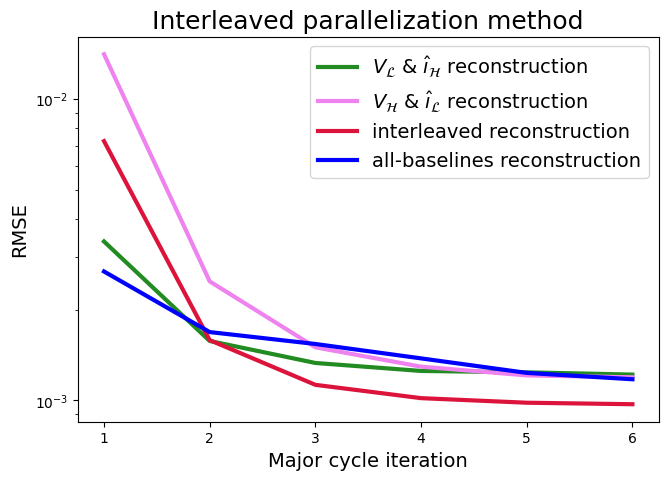

In [21]:
matplotlib.rcParams['figure.figsize'] = [7.5, 5]

plt.plot(range(1, 7), lowvis_rmse, c='forestgreen', label="${V_\mathcal{L}}$ & $\hat{\imath}_\mathcal{H}$ reconstruction", lw=3)
plt.plot(range(1, 7), highvis_rmse, c='violet', label="${V}_\mathcal{H}$ & $\hat{\imath}_\mathcal{L}$ reconstruction", lw=3)
plt.plot(range(1, 7), combined_rmse, c='crimson', label="interleaved reconstruction", lw=3)
#plt.plot(range(1, 11), data_high[0], c='b', label="serial", lw=3)
plt.plot(range(1, 7), single_full[0:6], c='b', label="all-baselines reconstruction", lw=3)

plt.xticks(range(1, 7))
plt.title("Interleaved parallelization method", fontsize=18)
plt.xlabel("Major cycle iteration", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.yscale('log')
plt.legend(loc="upper right", fontsize=14)

plt.savefig("../figures/presentation/interleaved_parallelization.png", bbox_inches='tight')

## What if we just add separately deconvolved together

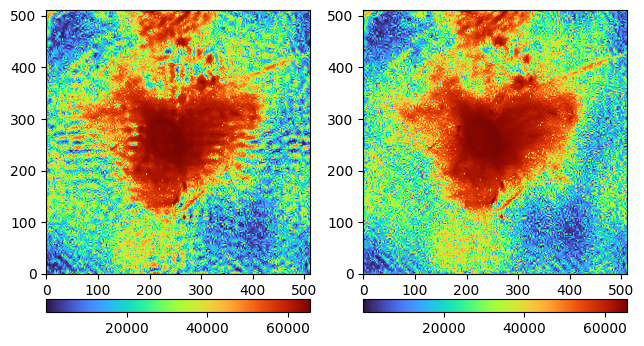

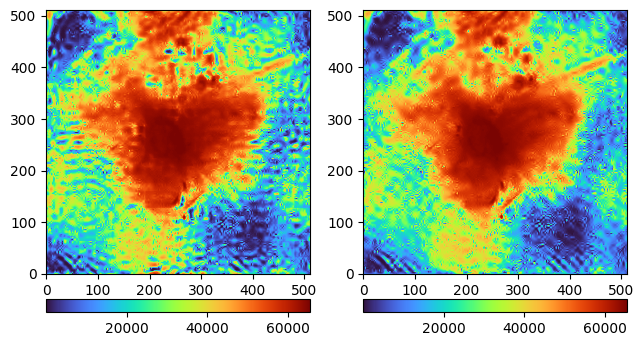

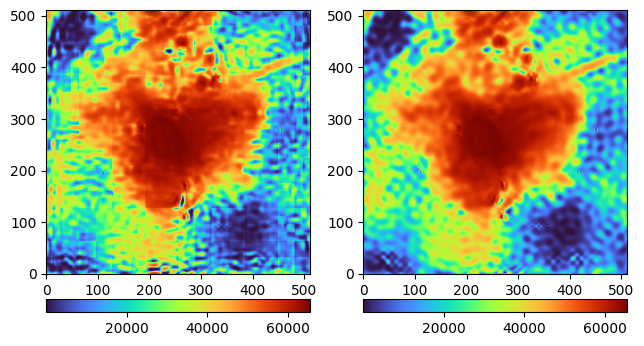

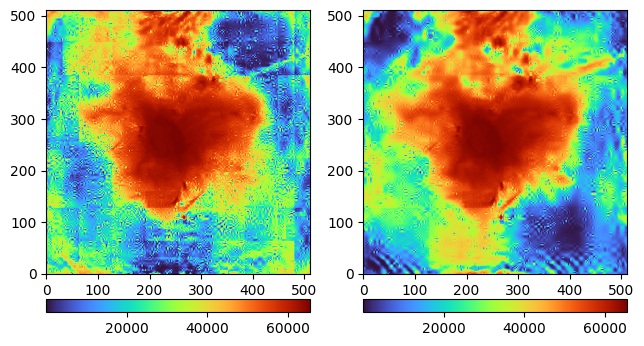

In [23]:
gt = helpers.readFits("../data/SGRA_full_gt.fits")
cut = 25

combined_rmse_naive = []
combined_rmse_filtered = []

lpfilter = helpers.bandpass(gt, 0, cut)
hpfilter = helpers.bandpass(gt, cut, 1000)
allfilter = helpers.bandpass(gt, 0, cut)

gtfiltered = signal.fftconvolve(gt, allfilter, mode='same')

lambdas = [0.025, 0.05, 0.1]#, 0.2, 0.5]

for l in lambdas:
    curr_deconv_low = None
    curr_deconv_high = None
    curr_rmses = []
    curr_rmses_filtered = []
    for maj_iter in range(0, 6):
        lowfn = "../results/cut_results/add_tests/" + str(l) + "/low/deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
        highfn = "../results/cut_results/add_tests/" + str(l) + "/high/deconv_iteration_" + str(maj_iter) + "_channel_0.fits"

        lowdeconv = helpers.readFits(lowfn)
        highdeconv = helpers.readFits(highfn)

        if curr_deconv_low is None:
            curr_deconv_low = lowdeconv
            curr_deconv_high = highdeconv
        else:
            curr_deconv_low += lowdeconv
            curr_deconv_high += highdeconv

        curr_deconv = curr_deconv_low + curr_deconv_high
            
        lowdeconv_filtered = signal.fftconvolve(curr_deconv_low, lpfilter, mode='same')
        highdeconv_filtered = signal.fftconvolve(curr_deconv_high, hpfilter, mode='same')
        curr_deconv_filtered = lowdeconv_filtered + highdeconv_filtered

        rmse_combined = helpers.compute_rmse(gt, curr_deconv)
        rmse_filtered = helpers.compute_rmse(gtfiltered, curr_deconv_filtered)

        curr_rmses.append(rmse_combined)
        curr_rmses_filtered.append(rmse_filtered)
        
    combined_rmse_naive.append(curr_rmses)
    combined_rmse_filtered.append(curr_rmses_filtered)
    
    helpers.plotNImages([helpers.image_histogram_equalization(curr_deconv, number_bins=2**16), \
                         helpers.image_histogram_equalization(curr_deconv_filtered, number_bins=2**16)], \
                        ["", "", "", ""], cmap=cmap)
    #helpers.plotNImages([curr_deconv, curr_deconv_filtered], \
    #                    ["", ""], cmap=cmap)

helpers.plotNImages([helpers.image_histogram_equalization(single_recon, number_bins=2**16),\
                     helpers.image_histogram_equalization(multi_recon, number_bins=2**16)], ["", ""], cmap)
#helpers.plotNImages([single2_equalized], [""], cmap, output_file="figures/presentation/single_smallerlambda.png")
#helpers.plotNImages([multi_equalized], [""], cmap, output_file="figures/presentation/multi_largerlambda.png")
#helpers.plotNImages([multi2_equalized],
#helpers.plotNImages([curr_deconv_low, curr_deconv_high], ["", ""], cmap=cmap)

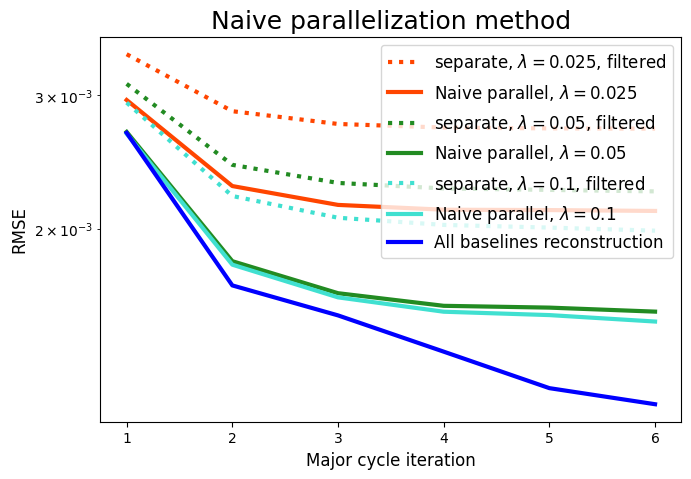

In [24]:
matplotlib.rcParams['figure.figsize'] = [7.5, 5]

cols=["orangered", "forestgreen", "turquoise", "violet", "crimson", "chocolate"]

for i, l in enumerate(lambdas):
    plt.plot(range(1, 7), combined_rmse_filtered[i], c=cols[i], linestyle=":", label="separate, $\lambda=" + str(l) + "$, filtered", lw=3)
    plt.plot(range(1, 7), combined_rmse_naive[i], c=cols[i], linestyle="-", label="Naive parallel, $\lambda=" + str(l) + "$", lw=3)

plt.plot(range(1, 7), single_full[0:6], c='blue', label="All baselines reconstruction", lw=3)
    
plt.title("Naive parallelization method", fontsize=18)
plt.xlabel("Major cycle iteration", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.yscale('log')
plt.legend(loc="upper right", fontsize=12)

plt.savefig("../figures/presentation/naive_split.png", bbox_inches='tight')